In [19]:
'''
Pre-Softmax-Supplier ParT for analyzing attention and interaction

Defines Batch, MultiHeadAttention, and multi_head_attention_forward such that they will return
pre-softmaxed attention and interaction matrices for analysis purposes alongside typical outputs.

This is achieved through forward hooks defined in Pre_Softmax_Hook such that the implementation of
ParT is not significantly altered.*

Passing the kwarg 'return_pre_softmax = True' (disabled by default) into a model configuration under
the ParticleTransformerWrapper class (just ParticleTransformer probably also works, but the latter 
has not been tested empirically) will enable this feature and allow usage of Pre_Softmax_Hook. While 
hooks are registered, Pre_Softmax_Hook will stack pre-softmaxed attention and interaction matrices 
for each input jet. This is a passive process and the only further interaction suggested is to call
pre_softmax_attentions or _interactions in order to view and analyze once you have run your model 
to satisfaction.

Initialize and register hooks via:

<Captain_Hook> = Pre_Softmax_Hook(model=<your_ParT_here>) # layer_name is also mentioned as a param
                                                            below but quickly became irrelevant
                                
                ----    Run your model  ----

Check results via:

<Captain_Hook>.pre_softmax_attentions
and
<Captain_Hook>.pre_softmax_interactions

(both are of shape (total_num_of_layers, num_heads, seq_length, seq_length)
where total_num_of_layers is the number of particle attention blocks that were passed through in
total by all jets in the sample)

                ----  Run your analysis  ----

Clear your hooks and give the captain some rest via:**

<Captain_Hook>.clear_hooks()

--------------------------------------------------------------------------------------------------

OTHER NOTES AND FOOTNOTES:

Keeping return_pre_softmax = False will leave the implementation functionally identical to original
Pytorch and ParT code.***

If you want to know whether any of this is optimized without needing to read the code, it's not.
Ditto for rigorous testing.

*Depends on your definition of 'significantly'. ParT computes in the exact way as before
and inner workings are 99% the same, but future edits made to the model will have to deal with
different output structures for multi_head_attention_forward, MultiheadAttention,
Block, and ParticleTransformer.

**You don't have to anthropomorphize your class instances in order for this to work. I just thought
it was funny.

***Currently untested. Also not really sure why you would do this if the hook doesn't appear to 
disrupt any other process, but I won't judge.
'''


from typing import List, Optional
import timeit
import awkward as ak
import torch
import torch.nn as nn
from torch.nn import Parameter 
from torch.nn.init import xavier_uniform_, xavier_normal_, constant_
import torch
from torch import nn, Tensor
from typing import Optional
import torch.nn.functional as F
from typing import Optional, Tuple
_is_fastpath_enabled: bool = True
from torch.overrides import (
    handle_torch_function,
    has_torch_function,
    has_torch_function_unary,
    has_torch_function_variadic,
)
linear = torch._C._nn.linear
import math
import random
import warnings
import copy
from torch._C import _add_docstr, _infer_size

from functools import partial
from weaver.utils.logger import _logger
import os
import uproot
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch._torch_docs import reproducibility_notes, sparse_support_notes, tf32_notes

class MultiheadAttention(nn.Module):

    __constants__ = ['batch_first']
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None, return_pre_softmax=False) -> None:
        if embed_dim <= 0 or num_heads <= 0:
            raise ValueError(
                f"embed_dim and num_heads must be greater than 0,"
                f" got embed_dim={embed_dim} and num_heads={num_heads} instead"
            )
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.return_pre_softmax = return_pre_softmax
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if not self._qkv_same_embed_dim:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super().__setstate__(state)

    def forward(
                self,
                query: Tensor,
                key: Tensor,
                value: Tensor,
                key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True,
                attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True,
                is_causal : bool = False,
                **kwargs) -> Tuple[Tensor, Optional[Tensor]]:

            why_not_fast_path = ''
            if ((attn_mask is not None and torch.is_floating_point(attn_mask))
            or (key_padding_mask is not None) and torch.is_floating_point(key_padding_mask)):
                why_not_fast_path = "floating-point masks are not supported for fast path."

            is_batched = query.dim() == 3

            key_padding_mask = _canonical_mask(
                mask=key_padding_mask,
                mask_name="key_padding_mask",
                other_type=_none_or_dtype(attn_mask),
                other_name="attn_mask",
                target_type=query.dtype
            )

            attn_mask = _canonical_mask(
                mask=attn_mask,
                mask_name="attn_mask",
                other_type=None,
                other_name="",
                target_type=query.dtype,
                check_other=False,
            )

            is_fastpath_enabled = get_fastpath_enabled()

            if not is_fastpath_enabled:
                why_not_fast_path = "torch.backends.mha.get_fastpath_enabled() was not True"
            elif not is_batched:
                why_not_fast_path = f"input not batched; expected query.dim() of 3 but got {query.dim()}"
            elif query is not key or key is not value:
                # When lifting this restriction, don't forget to either
                # enforce that the dtypes all match or test cases where
                # they don't!
                why_not_fast_path = "non-self attention was used (query, key, and value are not the same Tensor)"
            elif self.in_proj_bias is not None and query.dtype != self.in_proj_bias.dtype:
                why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_bias ({self.in_proj_bias.dtype}) don't match"
            elif self.in_proj_weight is None:
                why_not_fast_path = "in_proj_weight was None"
            elif query.dtype != self.in_proj_weight.dtype:
                # this case will fail anyway, but at least they'll get a useful error message.
                why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_weight ({self.in_proj_weight.dtype}) don't match"
            elif self.training:
                why_not_fast_path = "training is enabled"
            elif (self.num_heads % 2) != 0:
                why_not_fast_path = "self.num_heads is not even"
            elif not self.batch_first:
                why_not_fast_path = "batch_first was not True"
            elif self.bias_k is not None:
                why_not_fast_path = "self.bias_k was not None"
            elif self.bias_v is not None:
                why_not_fast_path = "self.bias_v was not None"
            elif self.add_zero_attn:
                why_not_fast_path = "add_zero_attn was enabled"
            elif not self._qkv_same_embed_dim:
                why_not_fast_path = "_qkv_same_embed_dim was not True"
            elif query.is_nested and (key_padding_mask is not None or attn_mask is not None):
                why_not_fast_path = "supplying both src_key_padding_mask and src_mask at the same time \
                                    is not supported with NestedTensor input"
            elif torch.is_autocast_enabled():
                why_not_fast_path = "autocast is enabled"

            if not why_not_fast_path:
                tensor_args = (
                    query,
                    key,
                    value,
                    self.in_proj_weight,
                    self.in_proj_bias,
                    self.out_proj.weight,
                    self.out_proj.bias,
                )
                # We have to use list comprehensions below because TorchScript does not support
                # generator expressions.
                if torch.overrides.has_torch_function(tensor_args):
                    why_not_fast_path = "some Tensor argument has_torch_function"
                elif _is_make_fx_tracing():
                    why_not_fast_path = "we are running make_fx tracing"
                elif not all(_check_arg_device(x) for x in tensor_args):
                    why_not_fast_path = ("some Tensor argument's device is neither one of "
                                        f"cpu, cuda or {torch.utils.backend_registration._privateuse1_backend_name}")
                elif torch.is_grad_enabled() and any(_arg_requires_grad(x) for x in tensor_args):
                    why_not_fast_path = ("grad is enabled and at least one of query or the "
                                        "input/output projection weights or biases requires_grad")
                if not why_not_fast_path:
                    merged_mask, mask_type = self.merge_masks(attn_mask, key_padding_mask, query)

                    if self.in_proj_bias is not None and self.in_proj_weight is not None:
                        return torch._native_multi_head_attention(
                            query,
                            key,
                            value,
                            self.embed_dim,
                            self.num_heads,
                            self.in_proj_weight,
                            self.in_proj_bias,
                            self.out_proj.weight,
                            self.out_proj.bias,
                            merged_mask,
                            need_weights,
                            average_attn_weights,
                            mask_type)

            any_nested = query.is_nested or key.is_nested or value.is_nested
            assert not any_nested, ("MultiheadAttention does not support NestedTensor outside of its fast path. " +
                                    f"The fast path was not hit because {why_not_fast_path}")

            if self.batch_first and is_batched:
                # make sure that the transpose op does not affect the "is" property
                if key is value:
                    if query is key:
                        query = key = value = query.transpose(1, 0)
                    else:
                        query, key = (x.transpose(1, 0) for x in (query, key))
                        value = key
                else:
                    query, key, value = (x.transpose(1, 0) for x in (query, key, value))

            if not self._qkv_same_embed_dim:
                if self.return_pre_softmax:
                    attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction = multi_head_attention_forward(
                        query, key, value, self.embed_dim, self.num_heads,
                        self.in_proj_weight, self.in_proj_bias,
                        self.bias_k, self.bias_v, self.add_zero_attn,
                        self.dropout, self.out_proj.weight, self.out_proj.bias,
                        training=self.training,
                        key_padding_mask=key_padding_mask, need_weights=need_weights,
                        attn_mask=attn_mask,
                        use_separate_proj_weight=True,
                        q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                        v_proj_weight=self.v_proj_weight,
                        average_attn_weights=average_attn_weights,
                        return_pre_softmax=self.return_pre_softmax
                )
                else:
                    attn_output, attn_output_weights = multi_head_attention_forward(
                        query, key, value, self.embed_dim, self.num_heads,
                        self.in_proj_weight, self.in_proj_bias,
                        self.bias_k, self.bias_v, self.add_zero_attn,
                        self.dropout, self.out_proj.weight, self.out_proj.bias,
                        training=self.training,
                        key_padding_mask=key_padding_mask, need_weights=need_weights,
                        attn_mask=attn_mask,
                        use_separate_proj_weight=True,
                        q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                        v_proj_weight=self.v_proj_weight,
                        average_attn_weights=average_attn_weights,
                        return_pre_softmax=self.return_pre_softmax
                )
            else:
                if self.return_pre_softmax:
                    attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction = multi_head_attention_forward(
                        query, key, value, self.embed_dim, self.num_heads,
                        self.in_proj_weight, self.in_proj_bias,
                        self.bias_k, self.bias_v, self.add_zero_attn,
                        self.dropout, self.out_proj.weight, self.out_proj.bias,
                        training=self.training,
                        key_padding_mask=key_padding_mask,
                        need_weights=need_weights,
                        attn_mask=attn_mask,
                        average_attn_weights=average_attn_weights,
                        return_pre_softmax=self.return_pre_softmax)
                else:
                    attn_output, attn_output_weights = multi_head_attention_forward(
                        query, key, value, self.embed_dim, self.num_heads,
                        self.in_proj_weight, self.in_proj_bias,
                        self.bias_k, self.bias_v, self.add_zero_attn,
                        self.dropout, self.out_proj.weight, self.out_proj.bias,
                        training=self.training,
                        key_padding_mask=key_padding_mask,
                        need_weights=need_weights,
                        attn_mask=attn_mask,
                        average_attn_weights=average_attn_weights,
                        return_pre_softmax=self.return_pre_softmax)

            if self.batch_first and is_batched:
                if self.return_pre_softmax:
                    pre_softmax_attention.detach()
                    pre_softmax_interaction.detach()
                    return {'output': attn_output.transpose(1, 0), 'attn_output_weights': attn_output_weights, 'pre_softmax_attention': pre_softmax_attention, 'pre_softmax_interaction': pre_softmax_interaction}
                else:
                    return attn_output.transpose(1, 0), attn_output_weights
            else:
                if self.return_pre_softmax:
                    pre_softmax_attention.detach()
                    pre_softmax_interaction.detach()
                    return {'output': attn_output, 'attn_output_weights': attn_output_weights, 'pre_softmax_attention': pre_softmax_attention, 'pre_softmax_interaction': pre_softmax_interaction}
                else:
                    return attn_output, attn_output_weights

def _canonical_mask(
    mask: Optional[Tensor],
    mask_name: str,
    other_type: Optional[torch.dtype],
    other_name: str,
    target_type: torch.dtype,
    check_other: bool = True,
) -> Optional[Tensor]:
    if mask is not None:
        _mask_dtype = mask.dtype
        _mask_is_float = torch.is_floating_point(mask)
        if _mask_dtype != torch.bool and not _mask_is_float:
            raise AssertionError(
                f"only bool and floating types of {mask_name} are supported"
            )
        if check_other and other_type is not None:
            if _mask_dtype != other_type:
                warnings.warn(
                    f"Support for mismatched {mask_name} and {other_name} "
                    "is deprecated. Use same type for both instead."
                )
        if not _mask_is_float:
            mask = torch.zeros_like(mask, dtype=target_type).masked_fill_(
                mask, float("-inf")
            )
    return mask
def _none_or_dtype(input: Optional[Tensor]) -> Optional[torch.dtype]:
    if input is None:
        return None
    elif isinstance(input, torch.Tensor):
        return input.dtype
    raise RuntimeError("input to _none_or_dtype() must be None or torch.Tensor")
def get_fastpath_enabled() -> bool:
    """Returns whether fast path for TransformerEncoder and MultiHeadAttention
    is enabled, or ``True`` if jit is scripting.

    ..note:
        The fastpath might not be run even if ``get_fastpath_enabled`` returns
        ``True`` unless all conditions on inputs are met.
    """
    if not torch.jit.is_scripting():
        return _is_fastpath_enabled
    return True



def set_fastpath_enabled(value: bool) -> None:
    """Sets whether fast path is enabled"""
    global _is_fastpath_enabled
    _is_fastpath_enabled = value

def multi_head_attention_forward(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    embed_dim_to_check: int,
    num_heads: int,
    in_proj_weight: Optional[Tensor],
    in_proj_bias: Optional[Tensor],
    bias_k: Optional[Tensor],
    bias_v: Optional[Tensor],
    add_zero_attn: bool,
    dropout_p: float,
    out_proj_weight: Tensor,
    out_proj_bias: Optional[Tensor],
    training: bool = True,
    key_padding_mask: Optional[Tensor] = None,
    need_weights: bool = True,
    attn_mask: Optional[Tensor] = None,
    use_separate_proj_weight: bool = False,
    q_proj_weight: Optional[Tensor] = None,
    k_proj_weight: Optional[Tensor] = None,
    v_proj_weight: Optional[Tensor] = None,
    static_k: Optional[Tensor] = None,
    static_v: Optional[Tensor] = None,
    average_attn_weights: bool = True,
    is_causal: bool = False,
    return_pre_softmax: bool = False,
) -> Tuple[Tensor, Optional[Tensor]]:
    tens_ops = (
        query,
        key,
        value,
        in_proj_weight,
        in_proj_bias,
        bias_k,
        bias_v,
        out_proj_weight,
        out_proj_bias,
    )
    if has_torch_function(tens_ops):
        return handle_torch_function(
            multi_head_attention_forward,
            tens_ops,
            query,
            key,
            value,
            embed_dim_to_check,
            num_heads,
            in_proj_weight,
            in_proj_bias,
            bias_k,
            bias_v,
            add_zero_attn,
            dropout_p,
            out_proj_weight,
            out_proj_bias,
            training=training,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            attn_mask=attn_mask,
            is_causal=is_causal,
            use_separate_proj_weight=use_separate_proj_weight,
            q_proj_weight=q_proj_weight,
            k_proj_weight=k_proj_weight,
            v_proj_weight=v_proj_weight,
            static_k=static_k,
            static_v=static_v,
            average_attn_weights=average_attn_weights,
            return_pre_softmax=return_pre_softmax,
        )

    is_batched = _mha_shape_check(
        query, key, value, key_padding_mask, attn_mask, num_heads
    )

    # For unbatched input, we unsqueeze at the expected batch-dim to pretend that the input
    # is batched, run the computation and before returning squeeze the
    # batch dimension so that the output doesn't carry this temporary batch dimension.
    if not is_batched:
        # unsqueeze if the input is unbatched
        query = query.unsqueeze(1)
        key = key.unsqueeze(1)
        value = value.unsqueeze(1)
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(0)

    # set up shape vars
    tgt_len, bsz, embed_dim = query.shape
    src_len, _, _ = key.shape

    key_padding_mask = _canonical_mask(
        mask=key_padding_mask,
        mask_name="key_padding_mask",
        other_type=_none_or_dtype(attn_mask),
        other_name="attn_mask",
        target_type=query.dtype,
    )

    if is_causal and attn_mask is None:
        raise RuntimeError(
            "Need attn_mask if specifying the is_causal hint. "
            "You may use the Transformer module method "
            "`generate_square_subsequent_mask` to create this mask."
        )

    if is_causal and key_padding_mask is None and not need_weights:
        # when we have a kpm or need weights, we need attn_mask
        # Otherwise, we use the is_causal hint go as is_causal
        # indicator to SDPA.
        attn_mask = None
    else:
        attn_mask = _canonical_mask(
            mask=attn_mask,
            mask_name="attn_mask",
            other_type=None,
            other_name="",
            target_type=query.dtype,
            check_other=False,
        )

        if key_padding_mask is not None:
            # We have the attn_mask, and use that to merge kpm into it.
            # Turn off use of is_causal hint, as the merged mask is no
            # longer causal.
            is_causal = False

    assert (
        embed_dim == embed_dim_to_check
    ), f"was expecting embedding dimension of {embed_dim_to_check}, but got {embed_dim}"
    if isinstance(embed_dim, torch.Tensor):
        # embed_dim can be a tensor when JIT tracing
        head_dim = embed_dim.div(num_heads, rounding_mode="trunc")
    else:
        head_dim = embed_dim // num_heads
    assert (
        head_dim * num_heads == embed_dim
    ), f"embed_dim {embed_dim} not divisible by num_heads {num_heads}"
    if use_separate_proj_weight:
        # allow MHA to have different embedding dimensions when separate projection weights are used
        assert (
            key.shape[:2] == value.shape[:2]
        ), f"key's sequence and batch dims {key.shape[:2]} do not match value's {value.shape[:2]}"
    else:
        assert (
            key.shape == value.shape
        ), f"key shape {key.shape} does not match value shape {value.shape}"

    #
    # compute in-projection
    #
    if not use_separate_proj_weight:
        assert (
            in_proj_weight is not None
        ), "use_separate_proj_weight is False but in_proj_weight is None"
        q, k, v = _in_projection_packed(query, key, value, in_proj_weight, in_proj_bias)
    else:
        assert (
            q_proj_weight is not None
        ), "use_separate_proj_weight is True but q_proj_weight is None"
        assert (
            k_proj_weight is not None
        ), "use_separate_proj_weight is True but k_proj_weight is None"
        assert (
            v_proj_weight is not None
        ), "use_separate_proj_weight is True but v_proj_weight is None"
        if in_proj_bias is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = in_proj_bias.chunk(3)
        q, k, v = _in_projection(
            query,
            key,
            value,
            q_proj_weight,
            k_proj_weight,
            v_proj_weight,
            b_q,
            b_k,
            b_v,
        )

    # prep attention mask

    if attn_mask is not None:
        # ensure attn_mask's dim is 3
        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            if attn_mask.shape != correct_2d_size:
                raise RuntimeError(
                    f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}."
                )
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
            if attn_mask.shape != correct_3d_size:
                raise RuntimeError(
                    f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}."
                )
        else:
            raise RuntimeError(
                f"attn_mask's dimension {attn_mask.dim()} is not supported"
            )

    # add bias along batch dimension (currently second)
    if bias_k is not None and bias_v is not None:
        assert static_k is None, "bias cannot be added to static key."
        assert static_v is None, "bias cannot be added to static value."
        k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
        v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))
    else:
        assert bias_k is None
        assert bias_v is None

    #
    # reshape q, k, v for multihead attention and make them batch first
    #
    q = q.view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if static_k is None:
        k = k.view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert (
            static_k.size(0) == bsz * num_heads
        ), f"expecting static_k.size(0) of {bsz * num_heads}, but got {static_k.size(0)}"
        assert (
            static_k.size(2) == head_dim
        ), f"expecting static_k.size(2) of {head_dim}, but got {static_k.size(2)}"
        k = static_k
    if static_v is None:
        v = v.view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert (
            static_v.size(0) == bsz * num_heads
        ), f"expecting static_v.size(0) of {bsz * num_heads}, but got {static_v.size(0)}"
        assert (
            static_v.size(2) == head_dim
        ), f"expecting static_v.size(2) of {head_dim}, but got {static_v.size(2)}"
        v = static_v

    # add zero attention along batch dimension (now first)
    if add_zero_attn:
        zero_attn_shape = (bsz * num_heads, 1, head_dim)
        k = torch.cat(
            [k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1
        )
        v = torch.cat(
            [v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1
        )
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    # update source sequence length after adjustments
    src_len = k.size(1)

    # merge key padding and attention masks
    if key_padding_mask is not None:
        assert key_padding_mask.shape == (
            bsz,
            src_len,
        ), f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = (
            key_padding_mask.view(bsz, 1, 1, src_len)
            .expand(-1, num_heads, -1, -1)
            .reshape(bsz * num_heads, 1, src_len)
        )
        if attn_mask is None:
            attn_mask = key_padding_mask
        else:
            attn_mask = attn_mask + key_padding_mask

    # adjust dropout probability
    if not training:
        dropout_p = 0.0

    #
    # (deep breath) calculate attention and out projection
    #

    if need_weights:
        B, Nt, E = q.shape
        q_scaled = q * math.sqrt(1.0 / float(E))

        assert not (
            is_causal and attn_mask is None
        ), "FIXME: is_causal not implemented for need_weights"

        if attn_mask is not None:
            pre_softmax_interaction = attn_mask.expand(-1,128,-1)
            pre_softmax_attention = torch.bmm(q_scaled, k.transpose(-2, -1))
            pre_softmax_attention.detach()
            pre_softmax_interaction.detach()
            attn_output_weights = torch.baddbmm(
                input=attn_mask, batch1=q_scaled, batch2=k.transpose(-2, -1)
            )
        else:
            attn_output_weights = pre_softmax_attention = torch.bmm(q_scaled, k.transpose(-2, -1))
        
        attn_output_weights = softmax(attn_output_weights, dim=-1)
        if dropout_p > 0.0:
            attn_output_weights = dropout(attn_output_weights, p=dropout_p)

        attn_output = torch.bmm(attn_output_weights, v)

        attn_output = (
            attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
        )
        attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
        attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))

        # optionally average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        if average_attn_weights:
            attn_output_weights = attn_output_weights.mean(dim=1)

        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
            attn_output_weights = attn_output_weights.squeeze(0)
        if return_pre_softmax:
            return attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction
        else:
            return attn_output, attn_output_weights
    else:
        # attn_mask can be either (L,S) or (N*num_heads, L, S)
        # if attn_mask's shape is (1, L, S) we need to unsqueeze to (1, 1, L, S)
        # in order to match the input for SDPA of (N, num_heads, L, S)
        if attn_mask is not None:
            if attn_mask.size(0) == 1 and attn_mask.dim() == 3:
                attn_mask = attn_mask.unsqueeze(0)
            else:
                attn_mask = attn_mask.view(bsz, num_heads, -1, src_len)

        q = q.view(bsz, num_heads, tgt_len, head_dim)
        k = k.view(bsz, num_heads, src_len, head_dim)
        v = v.view(bsz, num_heads, src_len, head_dim)

        attn_output = scaled_dot_product_attention(
            q, k, v, attn_mask, dropout_p, is_causal
        )
        attn_output = (
            attn_output.permute(2, 0, 1, 3).contiguous().view(bsz * tgt_len, embed_dim)
        )

        attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
        attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))
        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
        return attn_output, None
def _mha_shape_check(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    key_padding_mask: Optional[Tensor],
    attn_mask: Optional[Tensor],
    num_heads: int,
):
    # Verifies the expected shape for `query, `key`, `value`, `key_padding_mask` and `attn_mask`
    # and returns if the input is batched or not.
    # Raises an error if `query` is not 2-D (unbatched) or 3-D (batched) tensor.

    # Shape check.
    if query.dim() == 3:
        # Batched Inputs
        is_batched = True
        assert key.dim() == 3 and value.dim() == 3, (
            "For batched (3-D) `query`, expected `key` and `value` to be 3-D"
            f" but found {key.dim()}-D and {value.dim()}-D tensors respectively"
        )
        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 2, (
                "For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D"
                f" but found {key_padding_mask.dim()}-D tensor instead"
            )
        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), (
                "For batched (3-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                f" but found {attn_mask.dim()}-D tensor instead"
            )
    elif query.dim() == 2:
        # Unbatched Inputs
        is_batched = False
        assert key.dim() == 2 and value.dim() == 2, (
            "For unbatched (2-D) `query`, expected `key` and `value` to be 2-D"
            f" but found {key.dim()}-D and {value.dim()}-D tensors respectively"
        )

        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 1, (
                "For unbatched (2-D) `query`, expected `key_padding_mask` to be `None` or 1-D"
                f" but found {key_padding_mask.dim()}-D tensor instead"
            )

        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), (
                "For unbatched (2-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                f" but found {attn_mask.dim()}-D tensor instead"
            )
            if attn_mask.dim() == 3:
                expected_shape = (num_heads, query.shape[0], key.shape[0])
                assert (
                    attn_mask.shape == expected_shape
                ), f"Expected `attn_mask` shape to be {expected_shape} but got {attn_mask.shape}"
    else:
        raise AssertionError(
            f"query should be unbatched 2D or batched 3D tensor but received {query.dim()}-D query tensor"
        )

    return is_batched
def _in_projection_packed(
    q: Tensor,
    k: Tensor,
    v: Tensor,
    w: Tensor,
    b: Optional[Tensor] = None,
) -> List[Tensor]:
    r"""Perform the in-projection step of the attention operation, using packed weights.

    Output is a triple containing projection tensors for query, key and value.

    Args:
        q, k, v: query, key and value tensors to be projected. For self-attention,
            these are typically the same tensor; for encoder-decoder attention,
            k and v are typically the same tensor. (We take advantage of these
            identities for performance if they are present.) Regardless, q, k and v
            must share a common embedding dimension; otherwise their shapes may vary.
        w: projection weights for q, k and v, packed into a single tensor. Weights
            are packed along dimension 0, in q, k, v order.
        b: optional projection biases for q, k and v, packed into a single tensor
            in q, k, v order.

    Shape:
        Inputs:
        - q: :math:`(..., E)` where E is the embedding dimension
        - k: :math:`(..., E)` where E is the embedding dimension
        - v: :math:`(..., E)` where E is the embedding dimension
        - w: :math:`(E * 3, E)` where E is the embedding dimension
        - b: :math:`E * 3` where E is the embedding dimension

        Output:
        - in output list :math:`[q', k', v']`, each output tensor will have the
            same shape as the corresponding input tensor.
    """
    E = q.size(-1)
    if k is v:
        if q is k:
            # self-attention
            proj = linear(q, w, b)
            # reshape to 3, E and not E, 3 is deliberate for better memory coalescing and keeping same order as chunk()
            proj = (
                proj.unflatten(-1, (3, E))
                .unsqueeze(0)
                .transpose(0, -2)
                .squeeze(-2)
                .contiguous()
            )
            return proj[0], proj[1], proj[2]
        else:
            # encoder-decoder attention
            w_q, w_kv = w.split([E, E * 2])
            if b is None:
                b_q = b_kv = None
            else:
                b_q, b_kv = b.split([E, E * 2])
            q_proj = linear(q, w_q, b_q)
            kv_proj = linear(k, w_kv, b_kv)
            # reshape to 2, E and not E, 2 is deliberate for better memory coalescing and keeping same order as chunk()
            kv_proj = (
                kv_proj.unflatten(-1, (2, E))
                .unsqueeze(0)
                .transpose(0, -2)
                .squeeze(-2)
                .contiguous()
            )
            return (q_proj, kv_proj[0], kv_proj[1])
    else:
        w_q, w_k, w_v = w.chunk(3)
        if b is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = b.chunk(3)
        return linear(q, w_q, b_q), linear(k, w_k, b_k), linear(v, w_v, b_v)
def softmax(
    input: Tensor,
    dim: Optional[int] = None,
    _stacklevel: int = 3,
    dtype: Optional[torch.dtype] = None,
) -> Tensor:
    r"""Apply a softmax function.

    Softmax is defined as:

    :math:`\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}`

    It is applied to all slices along dim, and will re-scale them so that the elements
    lie in the range `[0, 1]` and sum to 1.

    See :class:`~torch.nn.Softmax` for more details.

    Args:
        input (Tensor): input
        dim (int): A dimension along which softmax will be computed.
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
          If specified, the input tensor is casted to :attr:`dtype` before the operation
          is performed. This is useful for preventing data type overflows. Default: None.

    .. note::
        This function doesn't work directly with NLLLoss,
        which expects the Log to be computed between the Softmax and itself.
        Use log_softmax instead (it's faster and has better numerical properties).

    """
    if has_torch_function_unary(input):
        return handle_torch_function(
            softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype
        )
    if dim is None:
        dim = _get_softmax_dim("softmax", input.dim(), _stacklevel)
    if dtype is None:
        ret = input.softmax(dim)
    else:
        ret = input.softmax(dim, dtype=dtype)
    return ret



def build_features_and_labels(tree, transform_features=True):
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x





''' Particle Transformer (ParT)

Paper: "Particle Transformer for Jet Tagging" - https://arxiv.org/abs/2202.03772
'''



@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None, **kwargs):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu


class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x, **kwargs):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None, **kwargs):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y


class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True, return_pre_softmax=False):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio
        self.return_pre_softmax = return_pre_softmax

        self.pre_attn_norm = nn.LayerNorm(embed_dim)

        self.attn = MultiheadAttention(
                embed_dim, 
                num_heads, 
                return_pre_softmax=self.return_pre_softmax,
                add_bias_kv=add_bias_kv
                )

        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, self.ffn_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None
        self.fc2 = nn.Linear(self.ffn_dim, embed_dim)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None

    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None, **kwargs):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            x_cls (Tensor, optional): class token input to the layer of shape `(1, batch, embed_dim)`
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape `(batch, seq_len)` where padding
                elements are indicated by ``1``.

        Returns:
            encoded output of shape `(seq_len, batch, embed_dim)`
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)

            if self.return_pre_softmax:
                dict_output = self.attn(x_cls, u, u, key_padding_mask=padding_mask, 
                                                                                     return_pre_softmax=self.return_pre_softmax
                                                                            )  # (1, batch, embed_dim)
                x = dict_output['output']  # (1, batch, embed_dim)
                pre_softmax_attention = dict_output['pre_softmax_attention']
                pre_softmax_interaction = dict_output['pre_softmax_interaction']

                pre_softmax_attention.detach()
                pre_softmax_interaction.detach()

            else:
                x, _ = self.attn(x_cls, u, u, key_padding_mask=padding_mask, 
                                    return_pre_softmax=self.return_pre_softmax
                                    )  # (1, batch, embed_dim)

        else:            
            residual = x
            x = self.pre_attn_norm(x)
            
            if self.return_pre_softmax:
                dict_output = self.attn(x, x, x, key_padding_mask=padding_mask, attn_mask=attn_mask,
                                         return_pre_softmax=self.return_pre_softmax
                                         )
                x = dict_output['output']
                pre_softmax_attention = dict_output['pre_softmax_attention']
                pre_softmax_interaction = dict_output['pre_softmax_interaction']

                pre_softmax_attention.detach()
                pre_softmax_interaction.detach()

            else:
                x, _ = self.attn(x, x, x, key_padding_mask=padding_mask,
                                attn_mask=attn_mask, return_pre_softmax=self.return_pre_softmax
                                )  # (seq_len, batch, embed_dim)

        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)

        x += residual.reshape(x.shape)

        residual = x
        x = self.pre_fc_norm(x)
        x = self.act(self.fc1(x))
        x = self.act_dropout(x)
        if self.post_fc_norm is not None:
            x = self.post_fc_norm(x)
        x = self.fc2(x)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        if self.return_pre_softmax:
            return {'output': x, 'pre_softmax_attention': pre_softmax_attention, 'pre_softmax_interaction': pre_softmax_interaction}
        else:
            return x


class ParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 return_pre_softmax=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.for_inference = for_inference
        self.use_amp = use_amp
        self.return_pre_softmax = return_pre_softmax
        self.num_layers = num_layers

        # init the collected pre_softmax matrices for later torch.cat()

        #if self.return_pre_softmax:
        #    self.pre_softmax_attention = torch.empty(0, dtype=torch.float32)
        #    self.pre_softmax_interaction = torch.empty(0, dtype=torch.float32)
        #    self.cls_pre_softmax_attention = torch.empty(0, dtype=torch.float32)
        #    self.cls_pre_softmax_interaction = torch.empty(0, dtype=torch.float32)

        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        self.default_cfg = default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True, return_pre_softmax=self.return_pre_softmax)
                           

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        # we want to add descriptive layer names, so use ModuleDict instead of List
        #self.blocks = nn.ModuleDict({f'Block_{i}': Block(**cfg_block) for i in range(num_layers)})
        #self.cls_blocks = nn.ModuleDict({f'cls_Block_{i}': Block(**cfg_cls_block) for i in range(num_cls_layers)})

        self.blocks = nn.ModuleList([Block(**cfg_block) for _ in range(num_layers)])
        self.cls_blocks = nn.ModuleList([Block(**cfg_cls_block) for _ in range(num_cls_layers)])
        self.norm = nn.LayerNorm(embed_dim)

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None, **kwargs):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            for block in self.blocks:
                if self.return_pre_softmax:
                    #x, pre_softmax_attention_vals, pre_softmax_interaction_vals = block(x, x_cls=None, padding_mask=padding_mask, 
                    #                                                          attn_mask=attn_mask, return_pre_softmax=self.return_pre_softmax)['output']
                    #pre_softmax_attention_vals = pre_softmax_attention_vals.unsqueeze(0)  # (N, num_heads, P, P)
                    #pre_softmax_interaction_vals = pre_softmax_interaction_vals.unsqueeze(0)  # (N, num_heads, P, P)

                    #self.pre_softmax_attention = torch.cat((self.pre_softmax_attention, pre_softmax_attention_vals), dim=0)
                    #self.pre_softmax_interaction = torch.cat((self.pre_softmax_interaction, pre_softmax_interaction_vals), dim=0)
                    x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask, return_pre_softmax=self.return_pre_softmax)['output']
                else:
                    x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask, return_pre_softmax=self.return_pre_softmax)

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                if self.return_pre_softmax:
                    cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask, return_pre_softmax=self.return_pre_softmax)['output']
                else:
                    cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)
            # print('output:\n', output)
            if self.return_pre_softmax:
                return output#, self.pre_softmax_attention, self.pre_softmax_interaction
            else:
                return output


class ParticleTransformerTagger(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, **kwargs):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            pf_x, pf_v, pf_mask, _ = self.pf_trimmer(pf_x, pf_v, pf_mask)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask)


class ParticleTransformerTaggerWithExtraPairFeatures(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp
        self.for_inference = for_inference

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, pf_uu=None, pf_uu_idx=None, **kwargs):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            if not self.for_inference:
                if pf_uu_idx is not None:
                    pf_uu = build_sparse_tensor(pf_uu, pf_uu_idx, pf_x.size(-1))

            pf_x, pf_v, pf_mask, pf_uu = self.pf_trimmer(pf_x, pf_v, pf_mask, pf_uu)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)
            uu = torch.zeros(v.size(0), pf_uu.size(1), v.size(2), v.size(2), dtype=v.dtype, device=v.device)
            uu[:, :, :pf_x.size(2), :pf_x.size(2)] = pf_uu

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask, uu)

class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)
        self.kwargs = kwargs

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        #if 'return_pre_softmax' in self.kwargs.keys() and self.kwargs['return_pre_softmax'] == True :
        #    output, pre_softmax_attention, pre_softmax_interaction = self.mod(features, v=lorentz_vectors, mask=mask)
        #    return output, pre_softmax_attention, pre_softmax_interaction
        #else:
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        return output

# Define Forward Hook to grab pre-softmax w/o altering outputs of forward() for ParticleTransformer

class Pre_Softmax_Hook:
    def __init__(self, model):
        self.model = model
        self.kwargs = self.model.kwargs

        if isinstance(self.model, ParticleTransformerWrapper):
            self.model = self.model.mod

        for module in self.model.blocks:
            #if layer_name in name:
                # register forward hook functions
            handle_attn = module.register_forward_hook(lambda *args, **kwargs: Pre_Softmax_Hook.get_pre_softmax_attention(self, *args, **kwargs))
            handle_inter = module.register_forward_hook(lambda *args, **kwargs: Pre_Softmax_Hook.get_pre_softmax_interaction(self, *args, **kwargs))

            print(f"Registered hook onto module")
        #else:
        #    print(f'A Layer does not match')

        # for now, we will not register hooks on class blocks
        # would not be too terribly difficult to implement, but it is not really the focus of current experiment

        #for module in self.model.cls_blocks:
            #if layer_name in name:
                # register forward hook function - no interaction in class blocks
            #cls_handle_attn = module.register_forward_hook(lambda *args, **kwargs: Pre_Softmax_Hook.get_pre_softmax_attention(self, *args, **kwargs))
            
            #print(f"Registered hook onto module")
        #else:
        #    print(f'Layer {module} does not match {layer_name}')

        self.handle_attn = handle_attn
        self.handle_inter = handle_inter
        #self.cls_handle_attn = cls_handle_attn

        self.embed_dim = self.model.default_cfg['embed_dim']
        self.num_heads = self.model.default_cfg['num_heads']
        self.seq_len = self.embed_dim

        self.pre_softmax_attentions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.pre_softmax_interactions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)

    # hooks will grab from the outputs of Block
    # meaning we don't need to modify forward methods for anything else
    # 3 hours later -- lol this was wrong

    def get_pre_softmax_attention(self, module, input, output):
        print('Getting pre_softmax attention...')

        # handle batching - we will divide 1st dimension by the number such that it will comport with num_heads

        output_hooked = output['pre_softmax_attention'].unsqueeze(dim=0)
        output_split = torch.split(output_hooked, self.num_heads, dim=1)

        print('Split the output into heads.\nNew Tensor Shapes:')
        for tensor in output_split:
            print(f'{tensor.shape}')

        for tensor in output_split:
            self.pre_softmax_attentions = torch.cat((self.pre_softmax_attentions, tensor), dim=0)

        # test to see if it will cat, if function is called

        #self.pre_softmax_attentions = torch.cat((self.pre_softmax_attentions, torch.randn((1,self.model.num_layers, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)), dim=0)

    def get_pre_softmax_interaction(self, module, input, output):
        print('Getting pre-softmaxed interaction...')

        output_hooked = output['pre_softmax_interaction'].unsqueeze(dim=0)
        output_split = torch.split(output_hooked, self.num_heads, dim=1)

        print(f'Got shape:{output_hooked.shape}')

        print('Split the output into heads.\nNew Tensor Shapes:')
        for tensor in output_split:
            print(f'{tensor.shape}')

        for tensor in output_split:
            self.pre_softmax_interactions = torch.cat((self.pre_softmax_interactions, tensor), dim=0)

    #def __call__(self, input_tensor: Tensor):
    #    output = self.model(input_tensor, **self.kwargs)
    #    return output

    def cut_padding(self, tensor, mask):
        '''
        Presents collected tensor from Pre_Softmax_Hook as list of particles with each item a 4d ndarray like (layers, heads, jet_length, jet_length).
        Padding removed.

        Args:
        - tensor: The input tensor to process.
        - config: Model configuration dict. If 'num_layers' is not present, defaults to 8 as in original ParT.

        Outputs:
        tensor_as_np: list of jagged arrays with shape (layers, heads, jet_length, jet_length)
        '''
        config = self.kwargs

        if 'num_layers' in config:
            num_layers = config['num_layers']
        else:
            num_layers = 8

        num_particles = tensor.shape[0] // num_layers

        tensor_as_np = tensor.numpy() # should be (total_num_layers, num_heads, jet_length, jet_length)
        tensor_as_np = np.split(tensor_as_np, indices_or_sections=num_particles, axis=0)

        for particle_idx, particle in enumerate(tensor_as_np):
            padding_limit = np.sum(mask[particle_idx])
            print(f'Padding Limit: {padding_limit}')
            padding_limit = np.sum(mask[particle_idx]).astype(int)
            tensor_as_np[particle_idx] = tensor_as_np[particle_idx][:,:,:padding_limit, :padding_limit]

        return tensor_as_np

    def clear(self):
        self.pre_softmax_attentions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.pre_softmax_interactions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.handle_attn.remove()
        self.handle_inter.remove()
        #self.cls_handle_attn.remove()

In [27]:
# testing with TL config and data

def get_model(model_type='qg',**kwargs):

    if model_type == 'qg':
        # QuarkGluon model configuration (13 kinpid features)
        cfg = dict(
            input_dim=13,  # pt_log, e_log, logptrel, logerel, deltaR, charge, isChargedHadron, isNeutralHadron, isPhoton, isElectron, isMuon, deta, dphi
            num_classes=2,  # Quark vs Gluon
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'tl':
        # TopLandscape model configuration (7 kinematic features)
        cfg = dict(
            input_dim=7,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi
            num_classes=2,  # Top vs QCD
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'jck':
        # JetClass kin model configuration (7 kinematic features)
        cfg = dict(
            input_dim=7,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi
            num_classes=10,
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'jck_pid':
        # JetClass kin model configuration (7 kinematic features)
        cfg = dict(
            input_dim=13,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi along with PID features
            num_classes=10,
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    else:
        print(f"Defaulting to Jet_Class-trained model configuration")
        cfg = dict(
            input_dim=17,
            num_classes=10,
            # network configurations
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            # misc
            trim=True,
            for_inference=False,
        )
    
    cfg.update(**kwargs)
    model = ParticleTransformerWrapper(**cfg)

    model_info = {

    }

    return model, model_info

test_ParT, model_info = get_model(model_type='qg', return_pre_softmax=True)

print(test_ParT.mod.return_pre_softmax)
print(test_ParT.mod.default_cfg)

print(f'Layer Names in test_ParT:')
for name in test_ParT.mod.blocks:
    print(name)
for name in test_ParT.mod.cls_blocks:
    print(name)

True
{'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True, 'return_pre_softmax': True}
Layer Names in test_ParT:
Block(
  (pre_attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): Linear(in_features=128, out_features=128, bias=True)
  )
  (post_attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (pre_fc_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (act): GELU(approximate='none')
  (act_dropout): Dropout(p=0.1, inplace=False)
  (post_fc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
)
Block(
  (pre_attn_norm): LayerNorm((128,), eps=1e-

In [21]:
# test that the model by itself can product outputs
# bring in actual data to verify this
# code from QG_and_TL_AttentionGraphs.ipynb

def build_features_and_labels_qg(tree, transform_features=True):
    """Build features for QuarkGluon dataset based on qg_kinpid.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on qg_kinpid.yaml
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for QuarkGluon (kinematic + particle ID)
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log', 
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for QuarkGluon (binary classification)
    out['label'] = a['label'].to_numpy().astype('int')
    
    return out

def build_features_and_labels_tl(tree, transform_features=True):
    """Build features for TopLandscape dataset based on top_kin.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label'])

    # compute new features (same as QG)
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on top_kin.yaml (same as QG)
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for TopLandscape (same kinematic features as QG)
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel', 
            'part_logerel',
            'part_deltaR',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for TopLandscape (binary classification) 
    out['label'] = a['label'].to_numpy().astype('int')

    return out

In [17]:
# loading TL data

def load_data(dataset_type='qg', batch_size=300):
    """
    Load data from 
    
    Args:
        dataset_type: 'qg', QuarkGluon, or 'tl', TopLandscape
        batch_size: Number of jets to load
    """

    try:
        if dataset_type == 'qg':
            # Try to load QuarkGluon data 
            data_path = "./qg_test_file_0.root"
            if os.path.exists(data_path):
                print(f"Loading QuarkGluon data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - QG')
                    data = build_features_and_labels_qg(tree)
                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size], 
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data

        elif dataset_type == 'tl':
            # Try to load TopLandscape data
            data_path = "./tl_test_file_0.root"
            if os.path.exists(data_path):
                print(f"Loading TopLandscape data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - TL')
                    data = build_features_and_labels_tl(tree)
                    # Truncate to batch_size
                    #if data['pf_points'].shape[0] > batch_size:
                    #    print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                    data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size],
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data
                
    except Exception as e:
        print(f"Could not load actual data: {e}")
        raise e

qg_data = load_data('qg', batch_size=10)
#tl_data = load_data('tl', batch_size=10)

#print(f"TL sample data shapes:")
#for k, v in tl_data.items():
#    print(f"  {k}: {v.shape}")

print(f"\nFeature dimensions:")
print(f"  QuarkGluon (kinpid): {qg_data['pf_features'].shape[1]} features")
#print(f"  TopLandscape (kin): {tl_data['pf_features'].shape[1]} features")

Loading QuarkGluon data from ./qg_test_file_0.root
This part is working - QG
Truncating from 99999 jets to 10 jets

Feature dimensions:
  QuarkGluon (kinpid): 13 features


In [28]:
# forward pass of model by itself to check that it can run

qgtrained_modelpath = '/home/tim_legge/save_qg_model/on-qg-run2_best_epoch_state.pt'
tltrained_modelpath = '/home/tim_legge/save_tl_model/on-tl-run3_best_epoch_state.pt'

qg_model = get_model('qg', return_pre_softmax=True)
qg_state_dict = torch.load(qgtrained_modelpath, map_location=torch.device('cpu'))
qg_model[0].load_state_dict(qg_state_dict)
qg_pf_features = qg_data['pf_features'][:]
qg_pf_vectors = qg_data['pf_vectors'][:]
qg_pf_mask = qg_data['pf_mask'][:]
qg_pf_points = qg_data['pf_points'][:]
qg_labels = qg_data['labels'][:]
qg_model[0].eval()
with torch.no_grad():
    qg_y_pred= qg_model[0](torch.from_numpy(qg_pf_points),torch.from_numpy(qg_pf_features),torch.from_numpy(qg_pf_vectors),torch.from_numpy(qg_pf_mask))

'''
tl_model = get_model('tl')
tl_state_dict = torch.load(tltrained_modelpath, map_location=torch.device('cpu'))
tl_model[0].load_state_dict(tl_state_dict)
tl_pf_features = tl_data['pf_features'][:]
tl_pf_vectors = tl_data['pf_vectors'][:]
tl_pf_mask = tl_data['pf_mask'][:]
tl_pf_points = tl_data['pf_points'][:]
tl_labels = tl_data['labels'][:]
tl_model[0].eval()
with torch.no_grad():
    tl_y_pred= tl_model[0](torch.from_numpy(tl_pf_points),torch.from_numpy(tl_pf_features),torch.from_numpy(tl_pf_vectors),torch.from_numpy(tl_pf_mask))
'''

/home/tim_legge/miniconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:396: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.


"\ntl_model = get_model('tl')\ntl_state_dict = torch.load(tltrained_modelpath, map_location=torch.device('cpu'))\ntl_model[0].load_state_dict(tl_state_dict)\ntl_pf_features = tl_data['pf_features'][:]\ntl_pf_vectors = tl_data['pf_vectors'][:]\ntl_pf_mask = tl_data['pf_mask'][:]\ntl_pf_points = tl_data['pf_points'][:]\ntl_labels = tl_data['labels'][:]\ntl_model[0].eval()\nwith torch.no_grad():\n    tl_y_pred= tl_model[0](torch.from_numpy(tl_pf_points),torch.from_numpy(tl_pf_features),torch.from_numpy(tl_pf_vectors),torch.from_numpy(tl_pf_mask))\n"

In [ ]:
'''
# access data from local .npys 

qgtrained_modelpath = '/home/tim_legge/save_qg_model/on-qg-run2_best_epoch_state.pt'
tltrained_modelpath = '/home/tim_legge/save_tl_model/on-tl-run3_best_epoch_state.pt'

qg_model = get_model('qg')
qg_state_dict = torch.load(qgtrained_modelpath, map_location=torch.device('cpu'))
qg_model[0].load_state_dict(qg_state_dict)
qg_pf_features = np.load('./qg_data/qg_pf_features.npy')[:200]
qg_pf_vectors = np.load('./qg_data/qg_pf_vectors.npy')[:200]
qg_pf_mask = np.load('./qg_data/qg_pf_mask.npy')[:200]
qg_pf_points = np.load('./qg_data/qg_pf_points.npy')[:200]
qg_labels = np.load('./qg_data/qg_labels.npy')[:200]
qg_model[0].eval()
with torch.no_grad():
    qg_y_pred= qg_model[0](torch.from_numpy(qg_pf_points),torch.from_numpy(qg_pf_features),torch.from_numpy(qg_pf_vectors),torch.from_numpy(qg_pf_mask))

print('QG done!')

tl_model = get_model('tl')
tl_state_dict = torch.load(tltrained_modelpath, map_location=torch.device('cpu'))
tl_model[0].load_state_dict(tl_state_dict)
tl_pf_features = np.load('./tl_data/tl_pf_features.npy')[:200]
tl_pf_vectors = np.load('./tl_data/tl_pf_vectors.npy')[:200]
tl_pf_mask = np.load('./tl_data/tl_pf_mask.npy')[:200]
tl_pf_points = np.load('./tl_data/tl_pf_points.npy')[:200]
tl_labels = np.load('./tl_data/tl_labels.npy')[:200]
tl_model[0].eval()
with torch.no_grad():
    tl_y_pred= tl_model[0](torch.from_numpy(tl_pf_points),torch.from_numpy(tl_pf_features),torch.from_numpy(tl_pf_vectors),torch.from_numpy(tl_pf_mask))
'''

/home/tim_legge/miniconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:396: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.


QG done!


In [7]:
qg_pf_mask.shape

(200, 1, 128)

In [29]:
# run clear in order to sample results again

test_hooks = Pre_Softmax_Hook(model=qg_model[0])

Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module


In [30]:
# forward pass with hooks enabled to collect pre-softmax attention and interaction matrices
    
qg_model[0].eval()
with torch.no_grad():
    qg_y_pred = qg_model[0](torch.from_numpy(qg_pf_points), torch.from_numpy(qg_pf_features), torch.from_numpy(qg_pf_vectors), torch.from_numpy(qg_pf_mask))



/home/tim_legge/miniconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:396: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.


Getting pre_softmax attention...
Split the output into heads.
New Tensor Shapes:
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
Getting pre-softmaxed interaction...
Got shape:torch.Size([1, 80, 128, 128])
Split the output into heads.
New Tensor Shapes:
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
Getting pre_softmax attention...
Split the output into heads.
New Tensor Shapes:
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([1, 8,

In [31]:
# check properties of test_hooks attention and interaction matrices

print(test_hooks.pre_softmax_attentions.shape)  # should be (num_layers, num_heads, seq_len, seq_len)
print(test_hooks.pre_softmax_interactions.shape)  # should be (num_layers, num_heads, seq_len, seq_len)

torch.Size([80, 8, 128, 128])
torch.Size([80, 8, 128, 128])


In [32]:
# print some values from both for another check

print(test_hooks.pre_softmax_attentions[0, 4, :5, :5])  # first layer, first head, first 5x5 block
print(test_hooks.pre_softmax_interactions[0, 4, :5, :5])  # first layer, fifth head, first 5x5 block

tensor([[-1.2176, -0.4486, -0.3218,  0.8992, -0.2738],
        [ 0.8333, -0.7658, -1.2811,  2.3147, -0.3020],
        [ 1.0842, -0.9406, -1.6114,  2.7736, -0.2049],
        [-0.5668, -0.5030, -0.8712,  0.0500, -1.4186],
        [-0.2683, -0.7890, -1.1187,  1.5517, -0.8685]])
tensor([[-1.6891e-01,  3.2437e-02,  9.3777e-02,  9.3310e-03, -4.2952e-03],
        [ 3.2437e-02, -9.0542e-02,  2.7070e+00,  9.8541e-02,  8.9705e+00],
        [ 9.3777e-02,  2.7070e+00, -9.0542e-02,  2.5419e-01,  3.3291e+00],
        [ 9.3310e-03,  9.8541e-02,  2.5419e-01, -1.6379e-01,  6.6095e-02],
        [-4.2952e-03,  8.9705e+00,  3.3291e+00,  6.6095e-02, -1.5106e-01]])


Implementation used here could be extended to pretty much any other variable that passes through Block.
I'm reminded of vector norm analysis here (https://arxiv.org/pdf/2004.10102) from Kobayashi et al.

In [ ]:
print(qg_pf_mask.shape)
print(qg_pf_mask[0,:,:45])

(6, 1, 128)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
# Now for some processing: cut out the padding and convert torch tensors to list of jagged ndarrays

pre_softmax_attention_as_np = test_hooks.cut_padding(test_hooks.pre_softmax_attentions, qg_pf_mask)
pre_softmax_interaction_as_np = test_hooks.cut_padding(test_hooks.pre_softmax_interactions, qg_pf_mask)

Padding Limit: 79.0
Padding Limit: 41.0
Padding Limit: 19.0
Padding Limit: 56.0
Padding Limit: 37.0
Padding Limit: 59.0
Padding Limit: 31.0
Padding Limit: 80.0
Padding Limit: 17.0
Padding Limit: 29.0
Padding Limit: 79.0
Padding Limit: 41.0
Padding Limit: 19.0
Padding Limit: 56.0
Padding Limit: 37.0
Padding Limit: 59.0
Padding Limit: 31.0
Padding Limit: 80.0
Padding Limit: 17.0
Padding Limit: 29.0


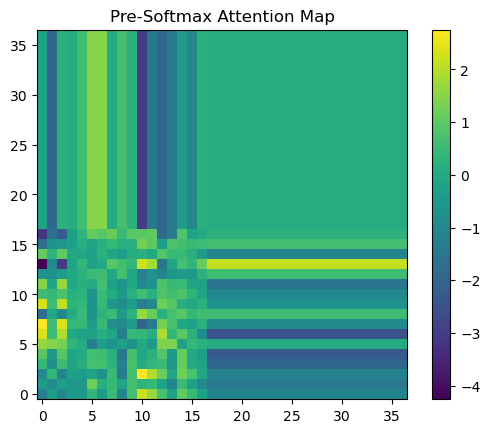

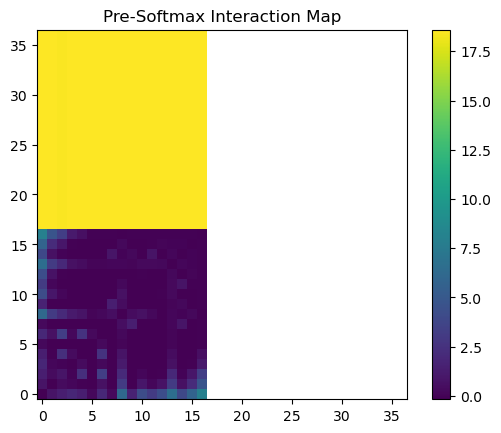

In [34]:
import matplotlib.pyplot as plt

jet_num = 4
head_num = 1
layer_num = 6

jet_length = len(pre_softmax_attention_as_np[jet_num][layer_num, head_num, 0, :])

plt.imshow(pre_softmax_attention_as_np[jet_num][layer_num, head_num, :, :], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Pre-Softmax Attention Map')

plt.xticks(np.arange(0, jet_length, step=5))  # Set x-axis ticks as integers with step size of 5
plt.yticks(np.arange(0, jet_length, step=5))

plt.show()

plt.imshow(pre_softmax_interaction_as_np[jet_num][layer_num, head_num, :, :], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Pre-Softmax Interaction Map')

plt.xticks(np.arange(0, jet_length, step=5))  # Set x-axis ticks as integers with step size of 5
plt.yticks(np.arange(0, jet_length, step=5))

plt.show()